---

In [ ]:
! pip install -q kaggle


In [ ]:
 from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jayavardhan8907","key":"7e89b4b43f1f0c0b459708d58632b5e1"}'}

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d 'sovitrath/diabetic-retinopathy-224x224-gaussian-filtered'

 99% 424M/427M [00:19<00:00, 25.9MB/s]
100% 427M/427M [00:19<00:00, 22.8MB/s]


In [ ]:
! unzip diabetic-retinopathy-224x224-gaussian-filtered.zip

Archive:  diabetic-retinopathy-224x224-gaussian-filtered.zip
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0024cdab0c1e.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/00cb6555d108.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0124dffecf29.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/01b3aed3ed4c.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0369f3efe69b.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/03e25101e8e8.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/04ac765f91a1.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/059bc89df7f4.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/05a5183c92d0.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0684311afdfc.png  
  inflating: gaussian_filtered_images/gaussian_filtered_images/Mild/0

In [ ]:
import sys
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from time import perf_counter
from pathlib import Path
from IPython.display import Image, display, Markdown

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf

import seaborn as sns

In [ ]:
def printmd(string):
    display(Markdown(string))

In [ ]:
imageDir = Path('/content/gaussian_filtered_images')

filepaths = list(imageDir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df = image_df.sample(frac=1).reset_index(drop = True)

image_df

Filepath           Label
0     /content/gaussian_filtered_images/gaussian_fil...        Moderate
1     /content/gaussian_filtered_images/gaussian_fil...           No_DR
2     /content/gaussian_filtered_images/gaussian_fil...           No_DR
3     /content/gaussian_filtered_images/gaussian_fil...            Mild
4     /content/gaussian_filtered_images/gaussian_fil...           No_DR
...                                                 ...             ...
3657  /content/gaussian_filtered_images/gaussian_fil...           No_DR
3658  /content/gaussian_filtered_images/gaussian_fil...           No_DR
3659  /content/gaussian_filtered_images/gaussian_fil...           No_DR
3660  /content/gaussian_filtered_images/gaussian_fil...  Proliferate_DR
3661  /content/gaussian_filtered_images/gaussian_fil...          Severe

[3662 rows x 2 columns]

## ***1. Visualization***<a class="anchor" id="1"></a>

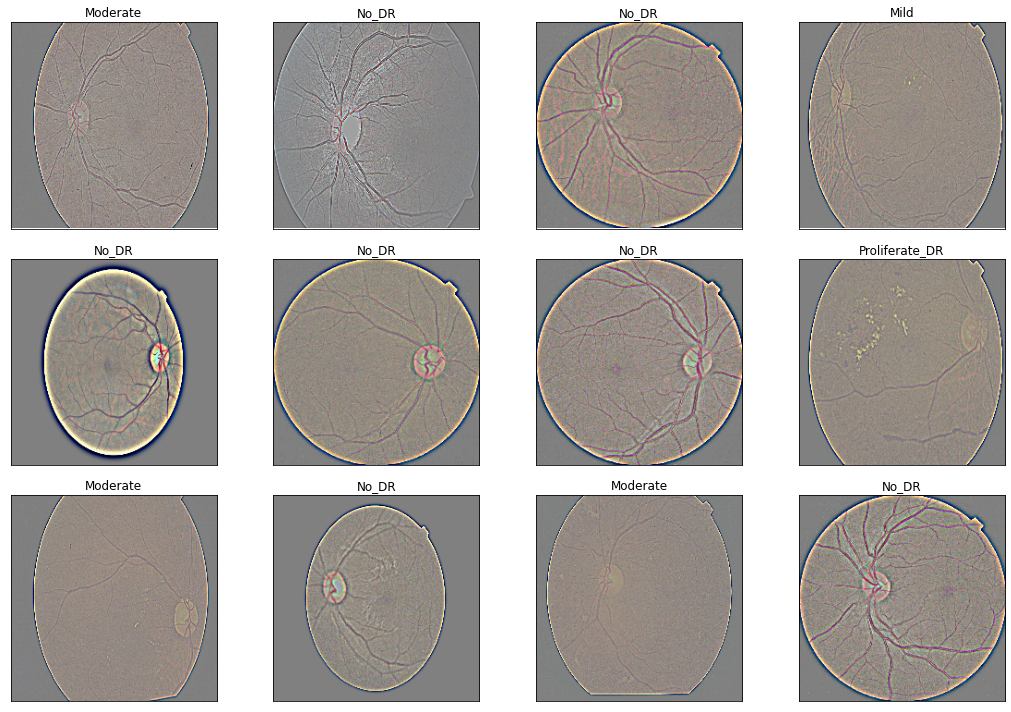

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])

plt.tight_layout()
plt.show()

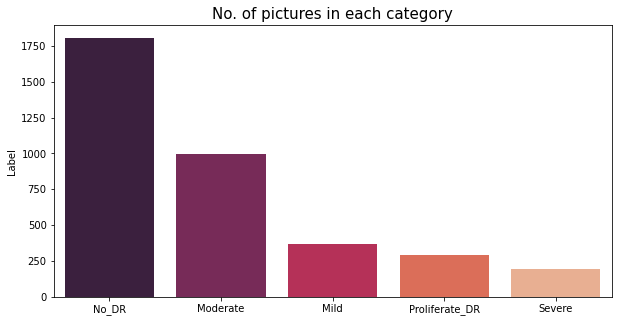

In [ ]:
vc = image_df['Label'].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=vc.index, y=vc, palette="rocket")
plt.title("No. of pictures in each category", fontsize=15)
plt.show()

## ***2. Load the Images with a generator***<a class="anchor" id="2"></a>

In [ ]:
def createGen():
    trainGen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    testGen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    trainImages = trainGen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    valImages = trainGen.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    testImages = testGen.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return trainGen, testGen, trainImages, valImages, testImages

## ***3. Test  canned architectures with pretrained weights***<a class="anchor" id="3"></a>

In [ ]:
def getModel(model):
    kwargs = {
        'input_shape':(224, 224, 3),
        'include_top':False,
        'weights':'imagenet',
        'pooling':'avg'
    }

    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [ ]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

In [ ]:
trainGen, testGen, trainImages, valImages, testImages = createGen()

for name, model in models.items():
    X = getModel(model['model'])
    models[name]['model'] = X

    start = perf_counter()
    history = X.fit(trainImages, validation_data=valImages, epochs=10)

    duration = round((perf_counter() - start), 2)
    models[name]['perf'] = duration
    print(f"{name:20} -> trained in -> {duration} Sec")

    valAcc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v, 4) for v in valAcc]

    trainAcc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v, 4) for v in trainAcc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.
Epoch 1/10
93/93 [==============================] - 22s 163ms/step - loss: 0.8743 - accuracy: 0.6871 - val_loss: 0.6926 - val_accuracy: 0.7599
Epoch 2/10
93/93 [==============================] - 11s 119ms/step - loss: 0.6602 - accuracy: 0.7620 - val_loss: 0.6511 - val_accuracy: 0.7933
Epoch 3/10
93/93 [==============================] - 11s 120ms/step - loss: 0.6208 - accuracy: 0.7731 - val_loss: 0.6216 - val_accuracy: 0.7751
Epoch 4/10
93/93 [==============================] - 11s 120ms/step - loss: 0.6005 - accuracy: 0.7734 - val_loss: 0.6337 - val_accuracy: 0.8055
Epoch 5/10
93/93 [==============================] - 11s 121ms/step - loss: 0.5889 - accuracy: 0.7819 - val_loss: 0.6422 - val_accuracy: 0.7538
Epoch 6/10
93/93 [==============================] - 11s 119ms/step - loss: 0.5420 - accuracy: 0.7950 - v

In [ ]:
modelsResult = []

for name, v in models.items():
    modelsResult.append(
        [
            name,
            models[name]['train_accuracy'][-1],
            models[name]['val_acc'][-1],
            models[name]['perf']
        ]
    )

dfResults = pd.DataFrame(
    modelsResult,
    columns = [
        'Model',
        'train_accuracy',
        'val_accuracy',
        'Training time (sec)'
    ]
)

dfResults.sort_values(by='val_accuracy', ascending=False, inplace=True)
dfResults.reset_index(inplace=True, drop=True)
dfResults

Model  train_accuracy  val_accuracy  Training time (sec)
0         DenseNet169          0.8361        0.8116               153.13
1           MobileNet          0.8510        0.8085                97.56
2         DenseNet201          0.8264        0.8024               181.52
3         ResNet101V2          0.8618        0.7994               183.79
4         DenseNet121          0.8129        0.7903               123.08
5   InceptionResNetV2          0.7795        0.7903               208.97
6         MobileNetV2          0.8564        0.7872               100.99
7               VGG16          0.7556        0.7812               201.67
8          ResNet50V2          0.8749        0.7751               130.40
9         InceptionV3          0.8402        0.7720               107.49
10              VGG19          0.7492        0.7690               203.59
11           Xception          0.8351        0.7660               174.98
12        ResNet152V2          0.8800        0.7629               268.96
13           ResNet50          0.7188        0.7386               156.24
14          ResNet152          0.6949        0.7264               304.48
15          ResNet101          0.6996        0.7173               224.44
16   MobileNetV3Large          0.6969        0.6991               100.94
17   MobileNetV3Small          0.6743        0.6809                97.72
18     EfficientNetB3          0.6446        0.6717               150.30
19       NASNetMobile          0.8112        0.6687               147.30
20     EfficientNetB4          0.6399        0.6626               188.22
21     EfficientNetB6          0.6396        0.6626               182.81
22     EfficientNetB7          0.6463        0.6565               191.87
23     EfficientNetB5          0.6372        0.6565               191.64
24     EfficientNetB2          0.5988        0.6353               128.15
25     EfficientNetB1          0.6052        0.6353               136.66
26     EfficientNetB0          0.5695        0.5532               110.02

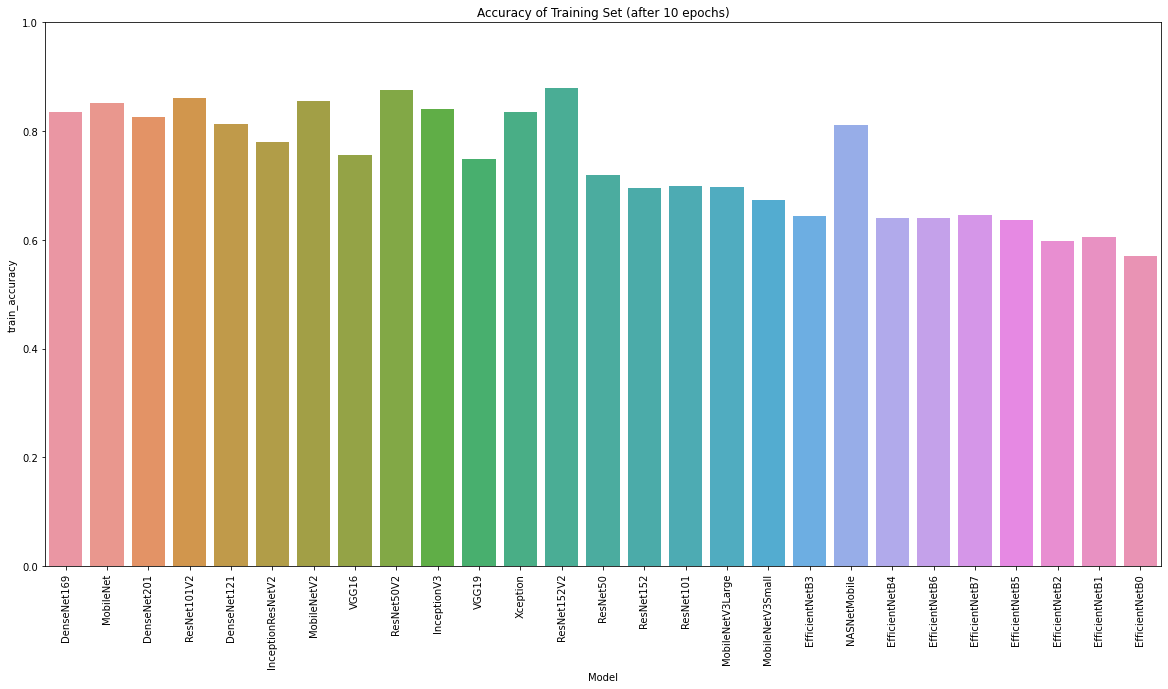

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Accuracy of Training Set (after 10 epochs)', fontsize=12)
sns.barplot(x='Model', y='train_accuracy', data=dfResults)
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.show()

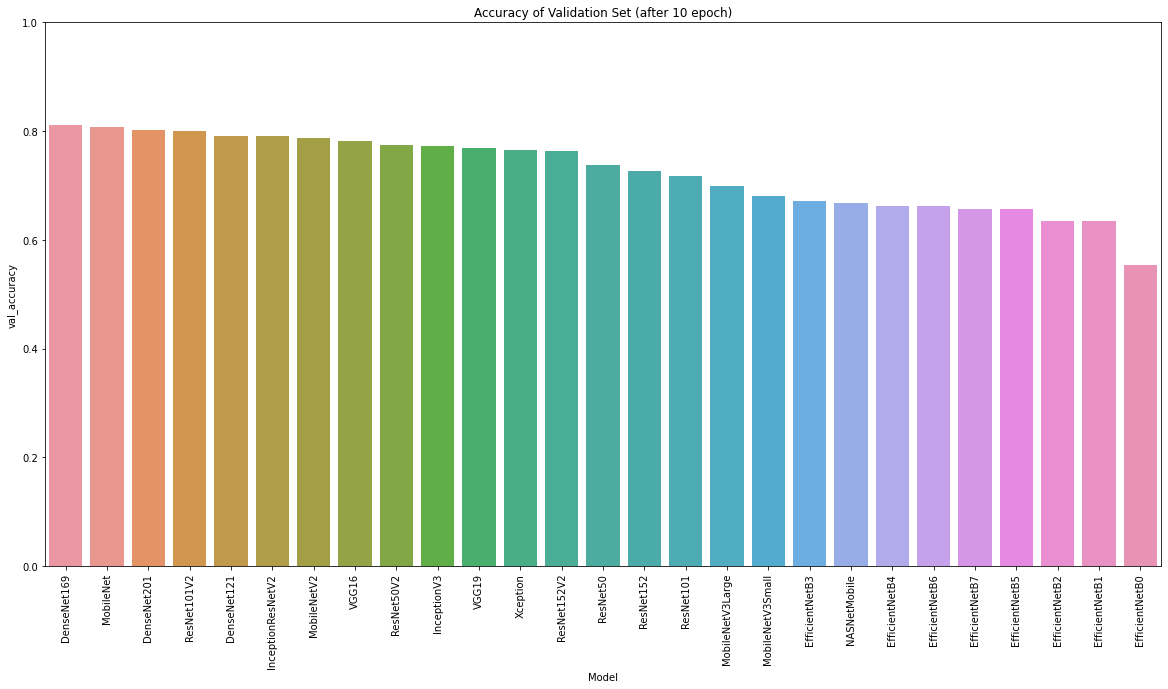

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Accuracy of Validation Set (after 10 epoch)', fontsize=12)
sns.barplot(x='Model', y='val_accuracy', data=dfResults)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

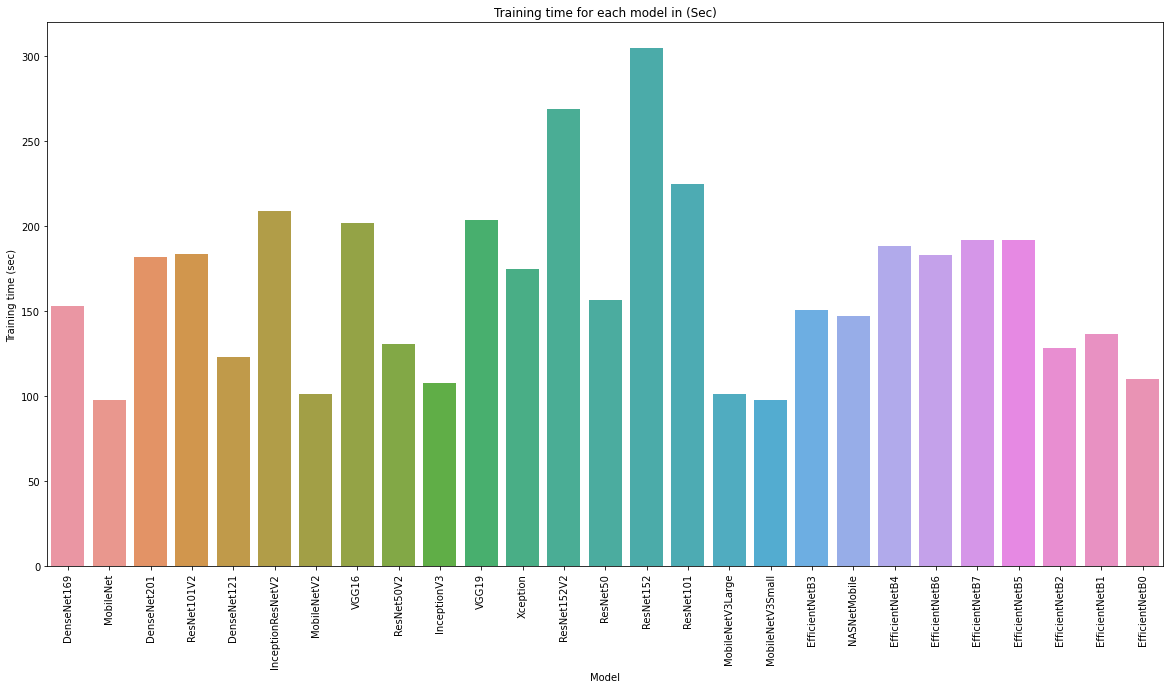

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x='Model', y='Training time (sec)', data=dfResults)
plt.title('Training time for each model in (Sec)', fontsize=12)
plt.xticks(rotation=90)
plt.show()

## ***4. Train the model MobileNetV2***<a class="anchor" id="4"></a>

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    trainImages,
    validation_data=valImages,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
93/93 [==============================] - 17s 158ms/step - loss: 0.7982 - accuracy: 0.7151 - val_loss: 0.6661 - val_accuracy: 0.7751
Epoch 2/10
93/93 [==============================] - 11s 117ms/step - loss: 0.6495 - accuracy: 0.7603 - val_loss: 0.6383 - val_accuracy: 0.7933
Epoch 3/10
93/93 [==============================] - 10s 102ms/step - loss: 0.6129 - accuracy: 0.7690 - val_loss: 0.5976 - val_accuracy: 0.7568
Epoch 4/10
93/93 [==============================] - 10s 104ms/step - loss: 0.5665 - accuracy: 0.7876 - val_loss: 0.5724 - val_accuracy: 0.7720
Epoch 5/10
93/93 [==============================] - 10s 103ms/step - loss: 0.5364 - accuracy: 0.7980 - val_loss: 0.6285 - val_accuracy: 0.7356
Epoch 6/10
93/93 [==============================] - 10s 102ms/step - loss: 0.5018 - accuracy: 0.8061 - val_loss: 0.5828 - val_accuracy: 0.7690


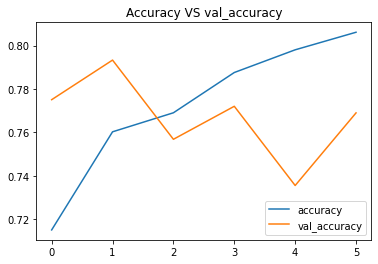

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy VS val_accuracy")
plt.show()

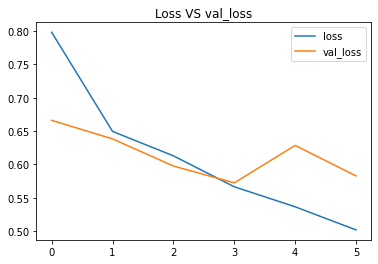

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss VS val_loss")
plt.show()

## ***5. Visualize the result***<a class="anchor" id="5"></a>

In [ ]:
results = model.evaluate(testImages, verbose=0)

printmd('> ## Test Loss |> {:.5f}'.format(results[0]))
printmd('> ## Accuracy |> {:.2f}%'.format(results[1] *100))

> ## Test Loss |> 0.53243

> ## Accuracy |> 79.84%

In [ ]:
pred = model.predict(testImages)
pred = np.argmax(pred,axis=1)

labels = (trainImages.class_indices)
labels = dict((v, k) for k, v in labels.items())

pred = [labels[k] for k in pred]

print(f'The first 10 predictions:\n{pred[:10]}')

12/12 [==============================] - 2s 88ms/step
The first 10 predictions:
['No_DR', 'No_DR', 'Proliferate_DR', 'No_DR', 'No_DR', 'Severe', 'No_DR', 'No_DR', 'No_DR', 'Moderate']


In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

          Mild       0.70      0.51      0.59        37
      Moderate       0.63      0.80      0.71        89
         No_DR       0.96      0.99      0.97       187
Proliferate_DR       0.52      0.31      0.39        36
        Severe       0.50      0.39      0.44        18

      accuracy                           0.80       367
     macro avg       0.66      0.60      0.62       367
  weighted avg       0.79      0.80      0.79       367



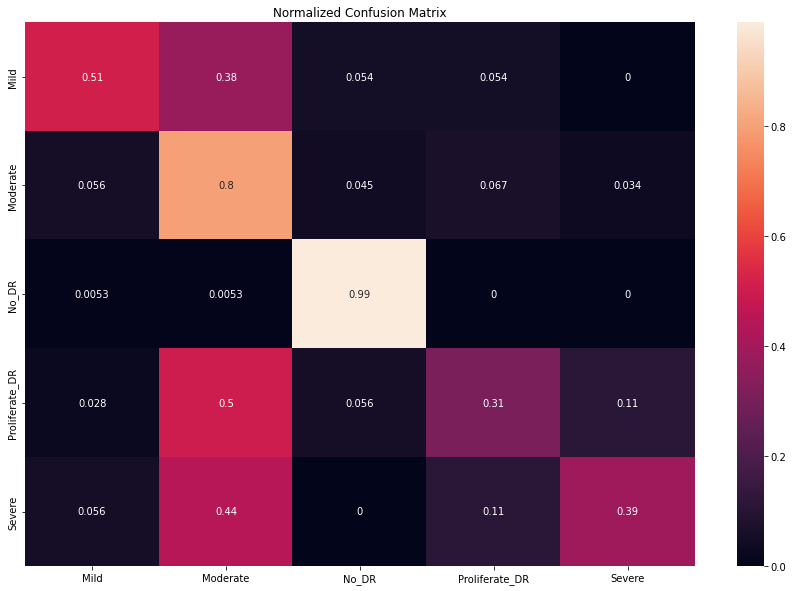

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15, 10))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

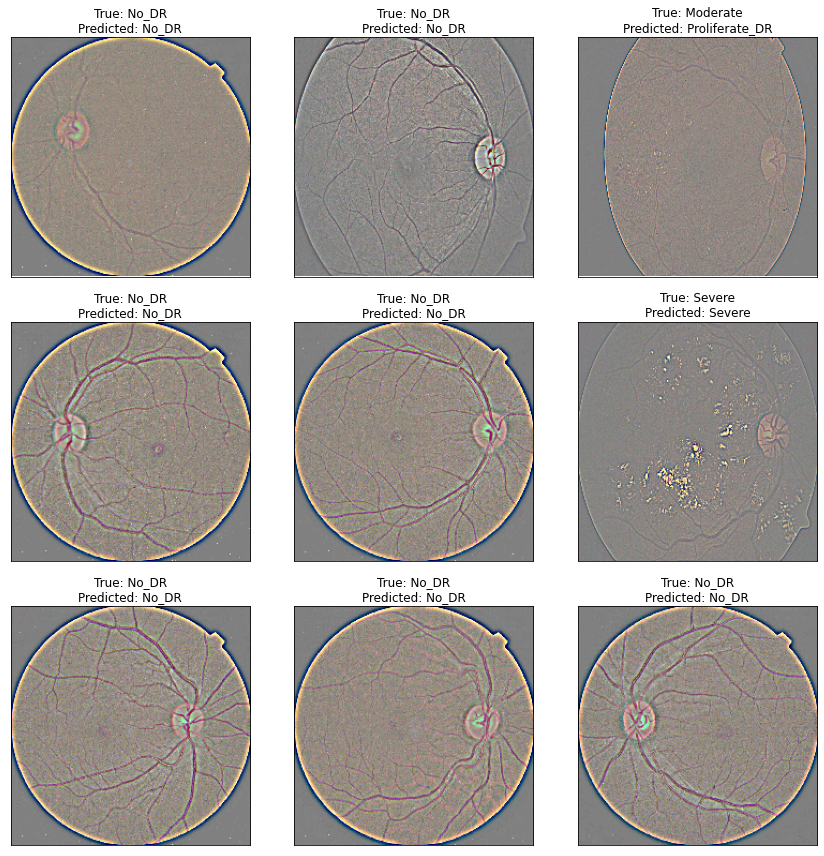

In [ ]:
fig, axes = plt.subplots(
    nrows=3, ncols=3,
    figsize=(12, 12),
    subplot_kw={'xticks':[], 'yticks':[]}
)

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f'True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}')

plt.tight_layout()
plt.show()

## ***6. Class activation heatmap for image classification***<a class="anchor" id="6"></a>
## Grad-CAM class activation visualization

In [ ]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None: pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]

    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    return cam_path

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224, 224)

model.layers[-1].activation = None

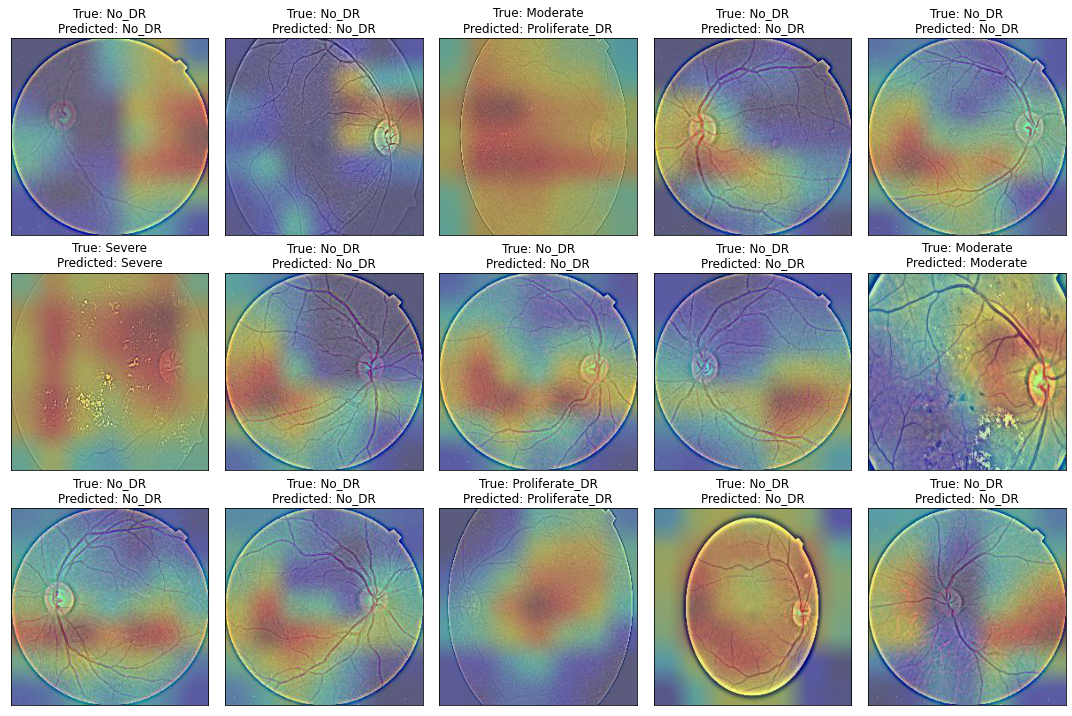

In [ ]:
fig, axes = plt.subplots(
    nrows=3,
    ncols=5,
    figsize=(15, 10),
    subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")

plt.tight_layout()
plt.show()

## ***7. Using a two-class model (DR and No_DR)***<a class="anchor" id="7"></a>
Map the labels to have only "No_DR" and "DR"

In [ ]:
image_df_red = image_df.copy()
image_df_red['Label'] = image_df_red['Label'].apply(lambda x: x if x=='No_DR' else 'DR')
image_df_red

Filepath  Label
0     /content/gaussian_filtered_images/gaussian_fil...     DR
1     /content/gaussian_filtered_images/gaussian_fil...  No_DR
2     /content/gaussian_filtered_images/gaussian_fil...  No_DR
3     /content/gaussian_filtered_images/gaussian_fil...     DR
4     /content/gaussian_filtered_images/gaussian_fil...  No_DR
...                                                 ...    ...
3657  /content/gaussian_filtered_images/gaussian_fil...  No_DR
3658  /content/gaussian_filtered_images/gaussian_fil...  No_DR
3659  /content/gaussian_filtered_images/gaussian_fil...  No_DR
3660  /content/gaussian_filtered_images/gaussian_fil...     DR
3661  /content/gaussian_filtered_images/gaussian_fil...     DR

[3662 rows x 2 columns]

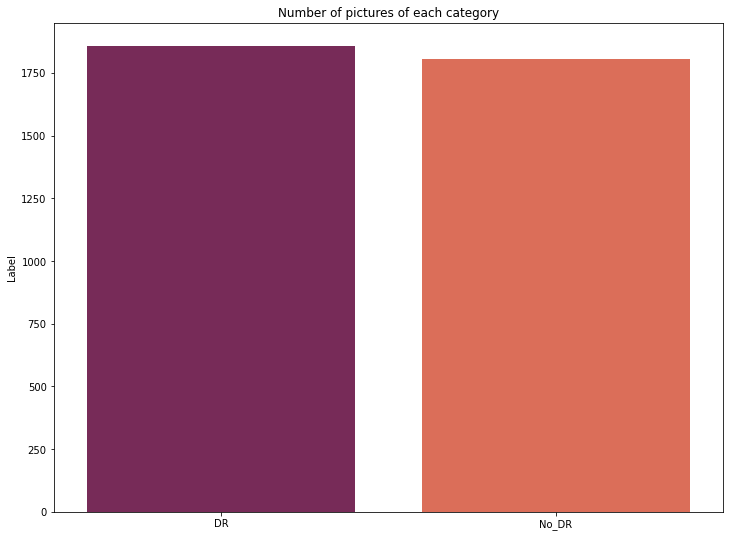

In [ ]:
vc = image_df_red['Label'].value_counts()
plt.figure(figsize=(12, 9))
sns.barplot(x=vc.index, y=vc, palette="rocket")
plt.title("Number of pictures of each category", fontsize=12)
plt.show()

In [ ]:
train_df, test_df = train_test_split(image_df_red, train_size=0.9, shuffle=True, random_state=1)

In [ ]:
trainGen, testGen, trainImages, valImages, testImages = createGen()

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    trainImages,
    validation_data=valImages,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Found 2966 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
Epoch 1/10
93/93 [==============================] - 22s 192ms/step - loss: 0.2081 - accuracy: 0.9262 - val_loss: 0.1529 - val_accuracy: 0.9544
Epoch 2/10
93/93 [==============================] - 10s 111ms/step - loss: 0.1409 - accuracy: 0.9575 - val_loss: 0.1298 - val_accuracy: 0.9514
Epoch 3/10
93/93 [==============================] - 10s 102ms/step - loss: 0.1127 - accuracy: 0.9639 - val_loss: 0.1340 - val_accuracy: 0.9514
Epoch 4/10
93/93 [==============================] - 9s 102ms/step - loss: 0.1010 - accuracy: 0.9656 - val_loss: 0.1522 - val_accuracy: 0.9483
Epoch 5/10
93/93 [==============================] - 10s 109ms/step - loss: 0.1158 - accuracy: 0.9622 - val_loss: 0.1646 - val_accuracy: 0.9514


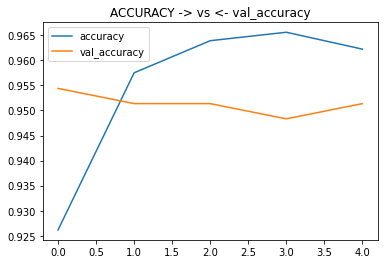

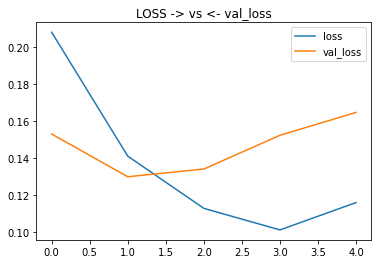

12/12 [==============================] - 1s 86ms/step - loss: 0.0994 - accuracy: 0.9673


> ## Test Loss |> 0.09935

> ## Accuracy |> 96.73%

12/12 [==============================] - 2s 86ms/step


The first 10 predictions:
 ['No_DR', 'DR', 'DR', 'No_DR', 'No_DR', 'DR', 'No_DR', 'No_DR', 'No_DR', 'DR']


               precision    recall  f1-score   support

          DR       0.98      0.96      0.97       180
       No_DR       0.96      0.98      0.97       187

    accuracy                           0.97       367
   macro avg       0.97      0.97      0.97       367
weighted avg       0.97      0.97      0.97       367



In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("ACCURACY -> vs <- val_accuracy")
plt.show()

pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("LOSS -> vs <- val_loss")
plt.show()

results = model.evaluate(testImages)

printmd('> ## Test Loss |> {:.5f}'.format(results[0]))
printmd('> ## Accuracy |> {:.2f}%'.format(results[1] *100))

pred = model.predict(testImages)
pred = np.argmax(pred,axis=1)

labels = (trainImages.class_indices)
labels = dict((v, k) for k, v in labels.items())

pred = [labels[k] for k in pred]
print(f'\n\nThe first 10 predictions:\n {pred[:10]}')

y_test = list(test_df.Label)
print(f'\n\n {classification_report(y_test, pred)}')

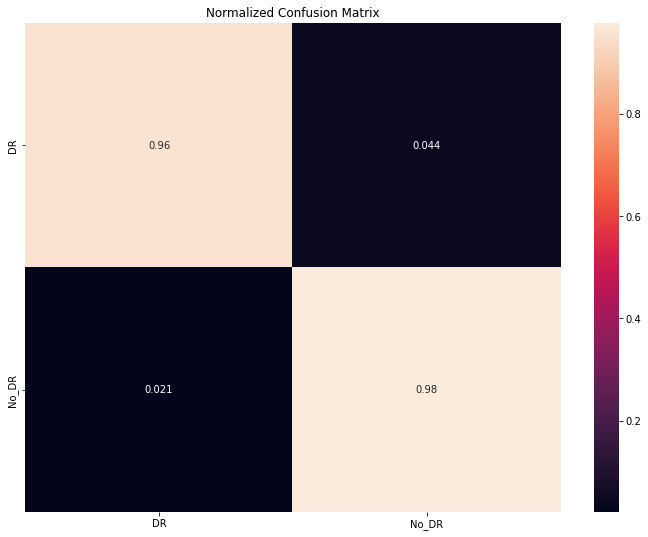

In [ ]:
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (12, 9))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

---